 # Time-Series Forecasting On UK Monthly Average Temperature
This project conducts a Univariate Time-Series analysis to forecast UK Monthly Average Temperature and compares the SARIMAX implementation versus auto_arima way. The SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model is an extension of the ARIMA ( Autoregressive Integrated Moving Average) model that allows for seasonality and exogenous variables. `auto_arima` is a function from the pmdarima library that automatically finds the best ARIMA/SARIMA model for a given time series. 

 ## Summary of results
Both models demonstrate strong performance, each achieving an R² score above 0.9. However, the SARIMAX model outperforms the best SARIMA model selected by `auto_arima`, delivering a superior fit with a lower RMSE of 1.12. When the optimal parameters (p, d, q)(P, D, Q, s) are known from domain knowledge or prior analysis, SARIMAX is the preferred choice. Conversely, for quickly establishing a baseline or prototype model without manual parameter tuning, auto_arima is an effective and convenient option.

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline


# Read Data

The dataset used in this project is downloaded from https://www.kaggle.com/datasets/aryakrishnanar/average-rainfall-and-temperature-in-uk20102019/data. It contains average rainfall (mm) and average temperature (Celsius degree) for the North East England and East England for period 2010-2019. 

In [6]:
df=pd.read_csv('avg_rainfalltemp in UK - Sheet1.csv')
df.head(20)

,Year,Type of period,Period,Avg rainfall(in mm),Avg temp(in centigrade)
0,2010,Monthly,JAN,69.5,0.80
1,2010,Monthly,FEB,71.7,1.60
2,2010,Monthly,MAR,65.1,5.50
3,2010,Monthly,APR,21.4,8.20
4,2010,Monthly,MAY,22.1,9.80
5,2010,Monthly,JUN,42.7,14.30
6,2010,Monthly,JUL,61.1,16.40
7,2010,Monthly,AUG,76.6,14.60
8,2010,Monthly,SEP,83.9,13.40
9,2010,Monthly,OCT,65.0,9.60


# Data Cleaning and EDA

In [7]:
df.shape

(170, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     170 non-null    int64  
 1   Type of period           170 non-null    object 
 2   Period                   170 non-null    object 
 3   Avg rainfall(in mm)      170 non-null    float64
 4   Avg temp(in centigrade)  170 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.8+ KB


In [9]:
# Extract monthly data
df=df[df['Type of period']=='Monthly']
df.head(20)

,Year,Type of period,Period,Avg rainfall(in mm),Avg temp(in centigrade)
0,2010,Monthly,JAN,69.5,0.8
1,2010,Monthly,FEB,71.7,1.6
2,2010,Monthly,MAR,65.1,5.5
3,2010,Monthly,APR,21.4,8.2
4,2010,Monthly,MAY,22.1,9.8
5,2010,Monthly,JUN,42.7,14.3
6,2010,Monthly,JUL,61.1,16.4
7,2010,Monthly,AUG,76.6,14.6
8,2010,Monthly,SEP,83.9,13.4
9,2010,Monthly,OCT,65.0,9.6


In [11]:
# Drop the irrelevant column as I am focusing on temperature forcast in this project
df=df.drop(['Type of period','Avg rainfall(in mm)'], axis=1)
# Combine the 'Year' and 'Period' into a new datetime column
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'], format='%Y-%b')
df.head()

,Year,Period,Avg temp(in centigrade),Date
0,2010,JAN,0.8,2010-01-01
1,2010,FEB,1.6,2010-02-01
2,2010,MAR,5.5,2010-03-01
3,2010,APR,8.2,2010-04-01
4,2010,MAY,9.8,2010-05-01


In [12]:
# Set the datetime as index
df2=df.set_index('Date').sort_index()
# Sets the datetime frequency; this is needed to preserve the datetime index for time series modeling and forcast
df2 = df2.asfreq('MS') # (MS = Month Start: M=Month End)
df2.head()


,Year,Period,Avg temp(in centigrade)
Date,,,
2010-01-01,2010,JAN,0.8
2010-02-01,2010,FEB,1.6
2010-03-01,2010,MAR,5.5
2010-04-01,2010,APR,8.2
2010-05-01,2010,MAY,9.8


In [13]:
# Change column names
df2.columns = ['Year', 'Month', 'Avg_Temp_C']
df2.head()

,Year,Month,Avg_Temp_C
Date,,,
2010-01-01,2010,JAN,0.8
2010-02-01,2010,FEB,1.6
2010-03-01,2010,MAR,5.5
2010-04-01,2010,APR,8.2
2010-05-01,2010,MAY,9.8


In [14]:
# check null values
df2.isna().sum()

Year          0
Month         0
Avg_Temp_C    0
dtype: int64

In [15]:
# Check whether the index has duplicates
duplicates = df2.index.duplicated()
print(df2[duplicates])

Empty DataFrame
Columns: [Year, Month, Avg_Temp_C]
Index: []


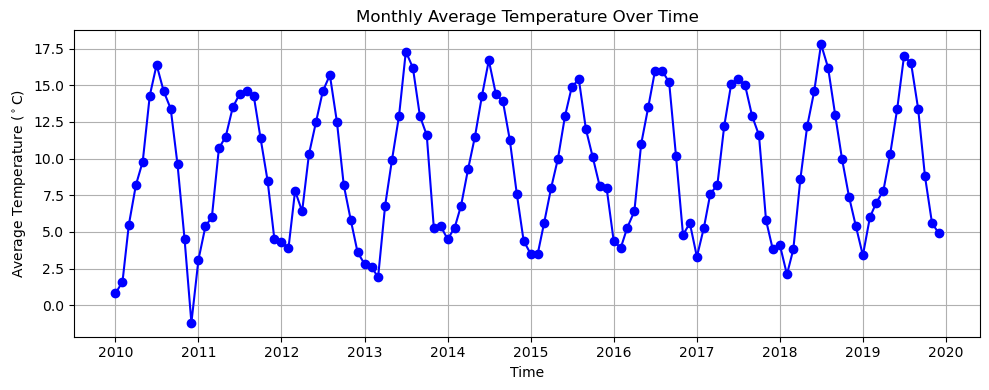

In [94]:
# Plot the temperature data
plt.figure(figsize=(10, 4))
plt.plot( df2['Avg_Temp_C'], marker='o', linestyle='-', color='b')
plt.title("Monthly Average Temperature Over Time")
plt.xlabel("Time")
plt.ylabel(r"Average Temperature ($^\circ$C)")
plt.grid(True)
plt.tight_layout()
#plt.savefig('Temperature_over_years.png')
plt.show()

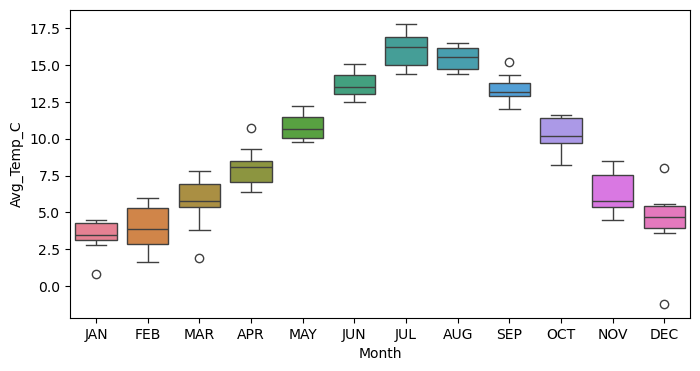

In [18]:
# check how the temperature is distributed on Months
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df2,
    x='Month',
    y='Avg_Temp_C',
    hue='Month',
)
#plt.savefig('Temperature_Box_Plot_Months.png')

* There is obvious seasonality in the monthly temperature data with July being the hottest month and January the coldest month

## Evaluating Stationarity

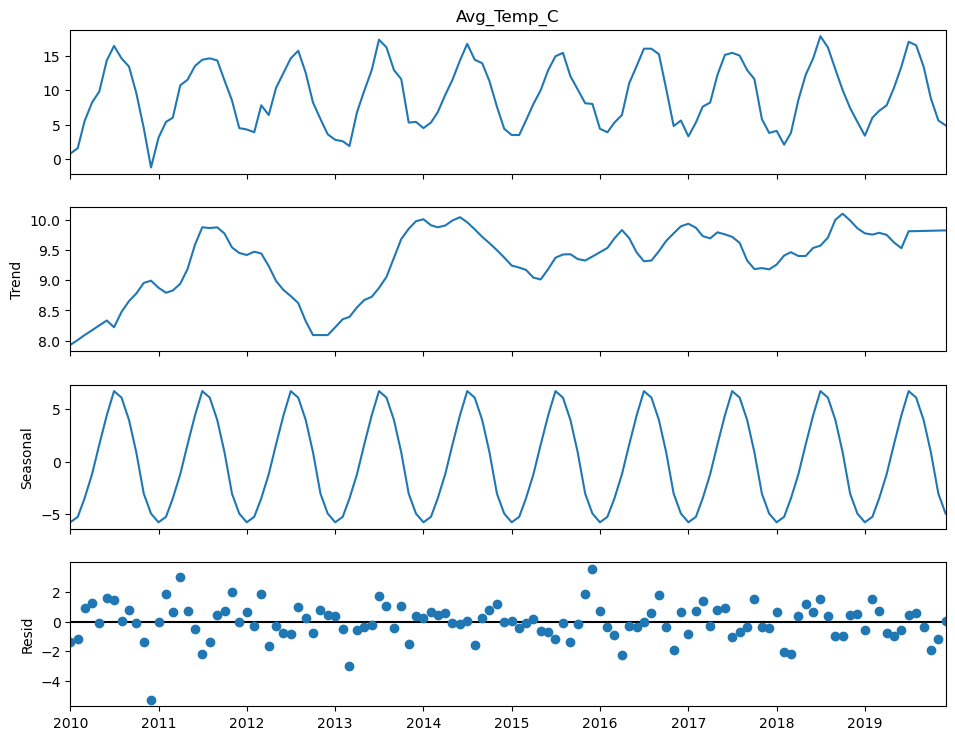

In [84]:
seasonal_temp = seasonal_decompose(df2.Avg_Temp_C,model='additive', extrapolate_trend ='freq', period=12) 
fig = seasonal_temp.plot()  
fig.set_size_inches(10, 8)
plt.show()

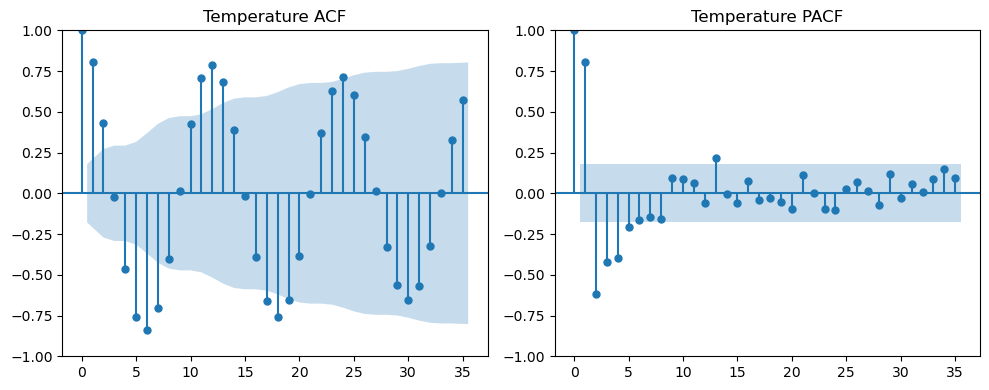

In [85]:
# Creat ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(df2['Avg_Temp_C'], ax=axes[0],lags=35)   
axes[0].set_title('Temperature ACF')

plot_pacf(df2['Avg_Temp_C'], ax=axes[1], lags=35)  
axes[1].set_title('Temperature PACF')
plt.tight_layout()
fig.savefig('Temperature_ACF_PACF.png', bbox_inches='tight')  
plt.show()

* The ACF Significant positive autocorrelations at lags 1, 2, 11, 12(peak positive), 13 and negative autocorrelation at lags 4, 5, 6 (peak nagative), 7, 17, 18. it decays slowly and shows an oscillatory behavior. This suggests the series has seasonality (d=1).
* The PACF plot shows statistically significant spikes at lags 1 and 2, with lag 1 being positive and lag 2 being negative. This suggests a potential AR(2) model (p=2) may be appropriate.

In [86]:
# # Augmented Dickey-Fuller Test’ to check whether the data is stationary or not
# # Method 1: use ADFTest in the ‘pmdarima’ package.
# # I found this method not as reliable 
# adf_test=ADFTest(alpha=0.05)
# adf_test.should_diff(df2['Avg_Temp_C'])

In [87]:
# Augmented Dickey-Fuller Test’ to check whether the data is stationary or not
# Method2: adfuller from statsmodels.tsa.stattools 
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df2['Avg_Temp_C']))


Test Statistic   -2.442458
p-value           0.130110
dtype: float64

* ADF test shows a p-value of 0.13. With the default p-value threshold alpha of 5%, p-value> alpha, we cannot reject the null hypothesis that the time series is non-stationary; this is consistent with previous ACF plot
* We will use differencing to remove trend/non-stationarity.

In [88]:
# Check the stationarity of the seasonal differencing data
temp_difference=df2['Avg_Temp_C'].diff(12).dropna() # drop null values as they affect the ACF plots
interpret_dftest(adfuller(temp_difference))

Test Statistic   -4.186685
p-value           0.000694
dtype: float64

* 1 order differencing removes non-stationarity, we can set d=1

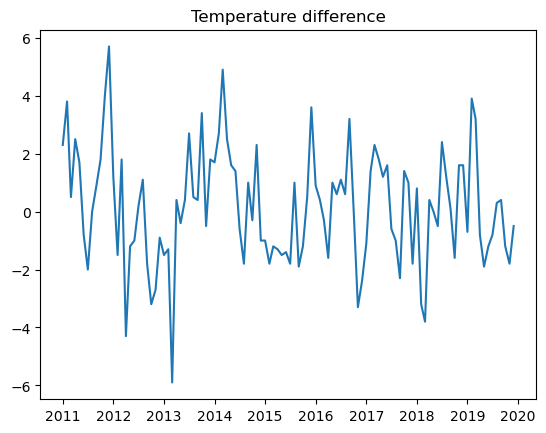

In [89]:
# Check the temperature difference and its ACF and PACF plots
plt.plot(temp_difference)
plt.title('Temperature difference')
plt.savefig('Temp_difference.png')
plt.show()

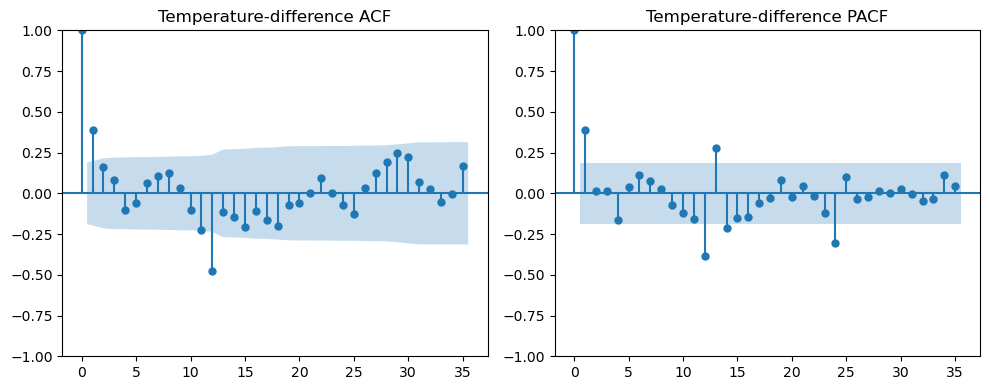

In [92]:
# Creat ACF and PACF plots of the difference
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(temp_difference, ax=axes[0], lags=35)   
axes[0].set_title('Temperature-difference ACF')

plot_pacf(temp_difference, ax=axes[1], lags=35)  
axes[1].set_title('Temperature-difference PACF')
plt.tight_layout()
fig.savefig('temp_difference_acf_pacf.png', bbox_inches='tight')  

* The ACF shows significant autocorrelation at lag 12, indicating that the residuals still have autocorrelation 1 seasonal period, thus a seasonal MA component Q=1 is appropriate.
* THe ACF also cuts off after lag 1, suggesting non-seasonal MA (q=1) may be appropriate.
* The PACF plot shows statistically significant spikes at lags 12 and 24, indicating seasonal autoregressive (AR) order P=2.
* So, combined with previous analysis for the temperature series ACF and PACF plots, in the SARIMA model, I will try model SARIMAX(2, 1, 1)x(2, 1, 1, 12)

## Prepare data for model construction

In [91]:
#  Split the data
train_size = int(len(df2['Avg_Temp_C']) * 0.8)

# ARIMA model family do not require feature scaling and model input data needs to be 1d
train = df2['Avg_Temp_C'][:train_size]
test = df2['Avg_Temp_C'][train_size:]

# check shapes
print(train.shape, test.shape)


(96,) (24,)


# Model Construction

## 1. SARIMAX model

In [53]:
# Fit SARIMA: (p,d,q)(P,D,Q,12) for yearly seasonality
model = SARIMAX(
    train,
    order=(2, 1, 1),
    seasonal_order=(2, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax= model.fit()
print(sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Avg_Temp_C   No. Observations:                   96
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -91.416
Date:                            Thu, 17 Jul 2025   AIC                            196.832
Time:                                    13:15:17   BIC                            211.133
Sample:                                01-01-2010   HQIC                           202.390
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2126      0.200      1.065      0.287      -0.179       0.604
ar.L2          0.1518      0.169   

## 2. Using pmdarima for Auto ARIMA model selection


In [51]:
# # Train auto_arima with seasonal=True
auto_arima = auto_arima(train,
                         start_p=0, start_q=0,
                         max_p=3, max_q=3, d=1,
                         seasonal=True,
                         start_P=0, start_Q=0,
                         max_P=3, max_Q=3, D=1,
                         m=12,                 
                         stepwise=False,
                         trace=True,
                         error_action='warn',
                         suppress_warnings=False,
                         maxiter=1000,
                        )
auto_arima.summary()

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=368.426, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=339.432, Time=0.10 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,0)(0,1,2)[12]             : AIC=338.678, Time=0.16 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=338.770, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=347.036, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=340.113, Time=0.09 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(1,1,2)[12]             : AIC=339.424, Time=0.47 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,0)(1,1,3)[12]             : AIC=340.728, Time=0.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=339.127, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=339.825, Time=0.19 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(2,1,2)[12]             : AIC=339.670, Time=0.55 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=338.177, Time=0.28 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=339.362, Time=0.54 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=2.86 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=354.763, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=325.328, Time=0.45 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(0,1,3)[12]             : AIC=325.976, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=339.362, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=326.240, Time=0.23 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.87 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(1,1,3)[12]             : AIC=326.999, Time=0.63 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=321.121, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=321.677, Time=0.32 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=320.533, Time=0.39 sec
 ARIMA(0,1,1)(3,1,1)[12]             : AIC=321.058, Time=0.61 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=352.751, Time=0.06 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.33 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,2)(0,1,2)[12]             : AIC=inf, Time=0.75 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,2)(0,1,3)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.41 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,2)(1,1,2)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,2)(3,1,0)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,3)(0,1,0)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=inf, Time=0.42 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,3)(0,1,2)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,3)(1,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,3)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,3)(2,1,0)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=360.118, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=332.411, Time=0.10 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=333.144, Time=0.25 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(0,1,3)[12]             : AIC=333.019, Time=0.33 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=343.534, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=333.948, Time=0.12 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,1,2)[12]             : AIC=336.379, Time=0.41 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,3)[12]             : AIC=334.561, Time=0.58 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=330.118, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=330.964, Time=0.26 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=329.879, Time=0.31 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=330.510, Time=0.63 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.50 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=0.73 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,1)(0,1,3)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.39 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.47 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,3)(0,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=360.007, Time=0.04 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=331.057, Time=0.14 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,1,0)(0,1,2)[12]             : AIC=331.584, Time=0.34 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(2,1,0)(0,1,3)[12]             : AIC=331.458, Time=0.57 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=342.721, Time=0.09 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=332.544, Time=0.23 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,1,0)(1,1,2)[12]             : AIC=335.029, Time=0.58 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=327.642, Time=0.20 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=328.465, Time=0.38 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=327.276, Time=0.39 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.42 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,1,1)(0,1,2)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.18 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,1,1)[12]             : AIC=inf, Time=0.56 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,1,0)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,3)(0,1,0)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=361.382, Time=0.04 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=332.559, Time=0.21 sec


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,1,0)(0,1,2)[12]             : AIC=332.849, Time=0.39 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=343.860, Time=0.10 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=333.927, Time=0.21 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=329.449, Time=0.24 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(3,1,1)(1,1,0)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,1)(3,1,0)[12]          


D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\D\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Total fit time: 55.120 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -155.266
Date:                             Thu, 17 Jul 2025   AIC                            320.533
Time:                                     13:07:35   BIC                            332.627
Sample:                                 01-01-2010   HQIC                           325.391
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7634      0.107     -7.160      0.000      -0.972      -0.554
ar.S.L12      -0.9378      0.181     -5.186      0.000      -1.292      -0.583
ar.S.L24      -0.7713      0.159     -4.866      0.000      -1.082      -0.461
ar.S.L36      -0.2499      0.164     -1.525      0.127      -0.571       0.071
sigma2         2.0269      0.316      6.414      0.000       1.408       2.646
===================================================================================
Ljung-Box (L1) (Q):                   2.84   Jarque-Bera (JB):                 6.51
Prob(Q):                              0.09   Prob(JB):                         0.04
Heteroskedasticity (H):               0.56   Skew:                             0.22
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* The best model from auto_arima  ARIMA(0,1,1)(3,1,0)[12] has higher AIC and BIC compared to the SARIMAX(2, 1, 1)x(2, 1, 1, 12), therefore the SARIMAX model is preferred
* Auto-arima uses different estimation/optimization strategies and complex seasonal models like (2,1,1)(2,1,1)[12] may take too long to converge or be skipped due to early convergence failures
* SARIMAX is the better choice when we already know a promising seasonal model structure from prior analysis.

# Model Validation

In [56]:
# Predictions with SARIMAX(2, 1, 1)x(2, 1, 1, 12)
temp_pred_sarimax = sarimax.forecast(len(test))
# Predictions with ARIMA(0,1,1)(3,1,0)[12] 
temp_pred_auto_arima, conf_int_auto_arima = auto_arima.predict(
    n_periods=len(test),
    return_conf_int=True,
    alpha=0.05
)

In [83]:
# Evaluate the model
rmse_sarimax = np.sqrt(mean_squared_error(test, temp_pred_sarimax ))
print(f'RMSE of SARIMAX(2, 1, 1)x(2, 1, 1, 12): {rmse_sarimax }')
rmse_auto_arima = np.sqrt(mean_squared_error(test, temp_pred_auto_arima ))
print(f'RMSE of ARIMA(0,1,1)(3,1,0)[12]: {rmse_auto_arima}')
print()

r2_sarimax = r2_score(test, temp_pred_sarimax)
print(f'r2 score of SARIMAX(2, 1, 1)x(2, 1, 1, 12) : {r2_sarimax }')
r2_auto_arima = r2_score(test, temp_pred_auto_arima)
print(f'r2 score of ARIMA(0,1,1)(3,1,0)[12] : {r2_auto_arima }')

RMSE of SARIMAX(2, 1, 1)x(2, 1, 1, 12): 1.1207409478987114
RMSE of ARIMA(0,1,1)(3,1,0)[12]: 1.2938219597842584

r2 score of SARIMAX(2, 1, 1)x(2, 1, 1, 12) : 0.9430916894832709
r2 score of ARIMA(0,1,1)(3,1,0)[12] : 0.9241572190439511


* SARIMAX(2, 1, 1)x(2, 1, 1, 12) model has better fitting and smaller mean squred error.

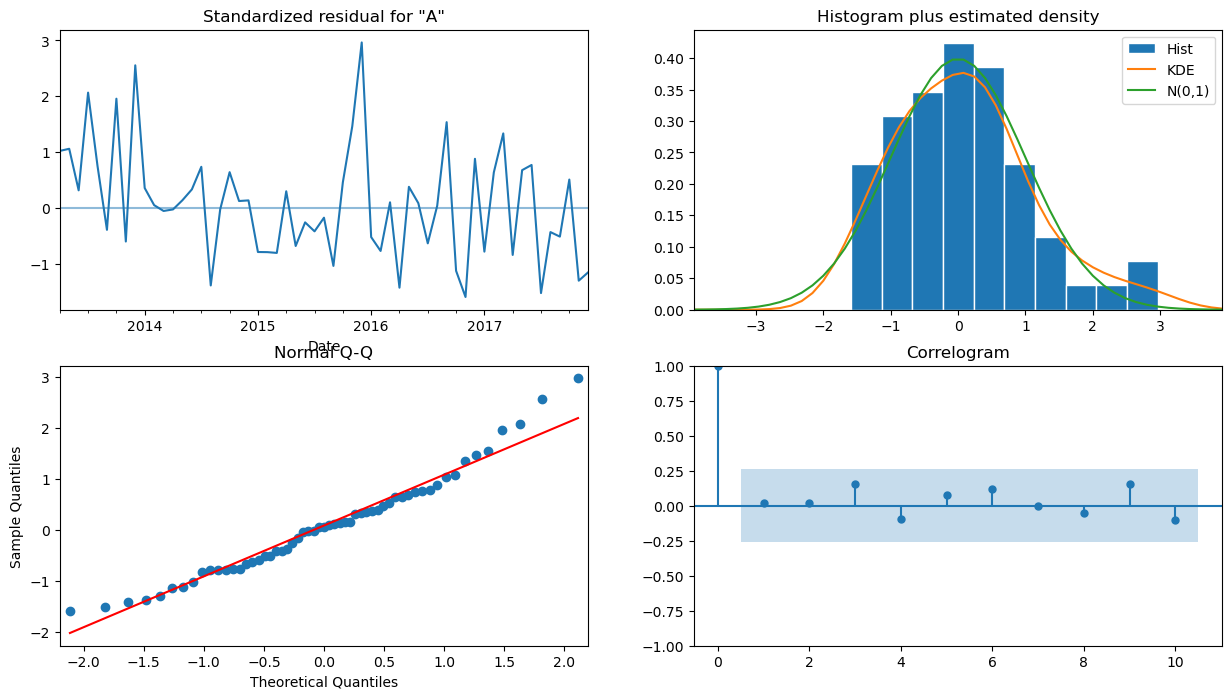

In [81]:
sarimax.plot_diagnostics(figsize=(15, 8))
plt.show()

* The plots show that the residuals are uncorrelated, normally distributed, and centered around zero

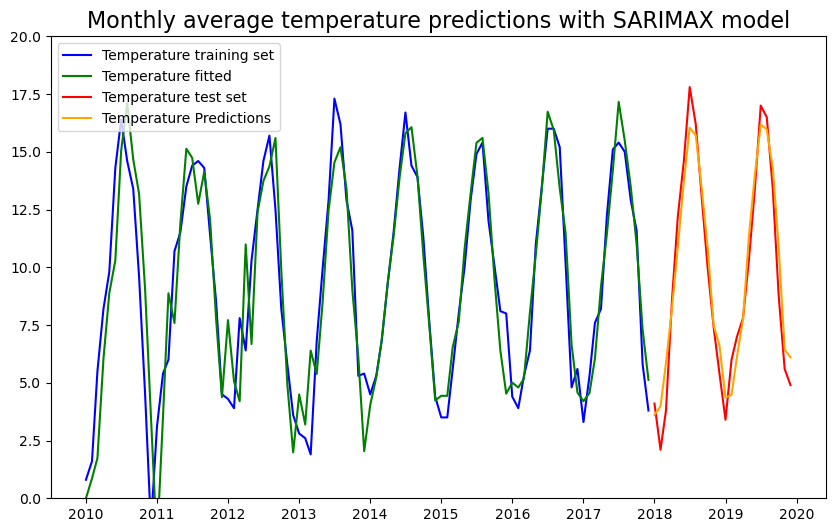

In [93]:
# Plot the predictions from SARIMAX(2, 1, 1)x(2, 1, 1, 12) model 

plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(train.index, train, color = 'blue', label = 'Temperature training set')
# Plot fitted data for the training set.
plt.plot(train.index, sarimax.fittedvalues, color = 'green', label = 'Temperature fitted')
# Plot testing data.
plt.plot(test.index, test, color = 'red', label = 'Temperature test set')
# Plot predicted test values.
plt.plot(test.index, temp_pred_sarimax , color = 'orange', label = 'Temperature Predictions')

plt.legend(loc = 'upper left')
plt.title(label = 'Monthly average temperature predictions with SARIMAX model', fontsize=16)
plt.ylim(0, 20)
plt.savefig('Temperature_Fitting_and_Predictions.jpg')
plt.show()

# Conclusions
Univariate Time-Series Analysis and Forcasting on UK Monthly Average Temperature with SARIMAX model and auto_arima is conducted in this project. With analysis of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, a promising seasonal model structure was proposed and trained with SARIMAX. Another model was trained using the `auto_arima` from the pmdarima library to the best SARIMA model hyperparameters.  

Both models demonstrate strong performance, each achieving an R² score above 0.9. However, the SARIMAX model outperforms the best SARIMA model selected by auto_arima, delivering a superior fit with a lower RMSE of 1.12. When the optimal parameters (p, d, q)(P, D, Q, s) are known from domain knowledge or prior analysis, SARIMAX is the preferred choice. Conversely, for quickly establishing a baseline or prototype model without manual parameter tuning, `auto_arima` is an effective and convenient option.